<a href="https://colab.research.google.com/github/sayid-alt/usd_idr_exchange_prediction/blob/model_without_outlier/usd_idr_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# # Run this code if you're using TPUv2-8 runtime
# !pip install yfinance statsmodels tensorflow==2.16.* keras-tuner -q

In [2]:
!pip install keras-tuner -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import urllib
import zipfile
import yfinance as yf
import os
import keras_tuner

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Lambda, Flatten, Dropout
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import files

In [4]:
print(tf.__version__)

2.17.0


# Utilities

In [5]:
# Plot series
def plot_series(df,
                columns,
                start_date=None,
                end_date=None,
                colors=['blue', 'red', 'green', 'brown'],
                fillbar=False
                ):
  """Plots multiple series from a Pandas DataFrame with different colors.

  Args:
    df: Pandas DataFrame containing the time series data.
    columns: A list of column names to plot.
    colors: A list of colors to use for each series.
  """
  # Ensure the DataFrame index is a DatetimeIndex
  if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

  # plot start and end series time if defined, if not, use entire dataframe
  df = df.loc[start_date:end_date] if start_date and end_date else df

  # add columns and rows
  if len(columns) > 1:
    ncols=2
    # adjust rows based on number of columns
    nrows=math.ceil(len(columns) / ncols)
  else:
    ncols=1
    nrows=1

  fig, ax = plt.subplots(figsize=(16, 5*nrows), ncols=ncols, nrows=nrows)
  if len(columns) > 1:
    ax = ax.flatten()
  # Iterate over the columns and plot each one
    for i, column in enumerate(columns):
      if fillbar:
        ax[i].fill_between(df.index, df[column].min(), df[column], alpha=0.7, color=colors[i % len(colors)])
      ax[i].plot(df.index, df[column], color=colors[i % len(colors)], label=column)
      ax[i].set_title(column)
      ax[i].set_xlabel("Time")
      ax[i].set_ylabel("Price")
      ax[i].legend()
      ax[i].grid(True)
  else:
    if fillbar:
      ax.fill_between(df.index, df[columns[0]].min(), df[columns[0]], alpha=0.7)
    ax.plot(df.index, df[columns[0]], color=colors[0], label=columns[0])
    ax.set_title(columns[0])
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()


def plot_history(history):
  fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
  print(history.history.keys())

  params = history.history.keys()
  epochs = range(len(history.history['loss']))


  # Iterate over axes objects in the grid
   # Access and iterate over individual axes in the grid
  for i, param in enumerate(['loss', 'mae']):
    ax[i].set_title(param)
    ax[i].plot(epochs, history.history[param], label=param)
    ax[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].grid(True)
    ax[i].legend()

  plt.show()

# Generate Data

## Extract data

---






This process of extracting data from yahoo finance using yfinance python library. The extacted dataset has been saved to the github account for fixed date range of dataset.
<br><br>
The Downloaded dataset then pushed into the github account for access it as public. <br> To access the dataset on github repository please visit this <a href="https://github.com/sayid-alt/usd_idr_exchange_prediction/tree/main/datasets">link<a/>.

In [6]:
idrx = yf.Ticker("IDR=X")
idrx.info

{'maxAge': 86400,
 'priceHint': 4,
 'previousClose': 15575.0,
 'open': 15624.0,
 'dayLow': 15624.0,
 'dayHigh': 15634.0,
 'regularMarketPreviousClose': 15575.0,
 'regularMarketOpen': 15624.0,
 'regularMarketDayLow': 15624.0,
 'regularMarketDayHigh': 15634.0,
 'bid': 15634.0,
 'ask': 15644.0,
 'fiftyTwoWeekLow': 14379.8,
 'fiftyTwoWeekHigh': 16510.2,
 'fiftyDayAverage': 15451.414,
 'twoHundredDayAverage': 15864.683,
 'currency': 'IDR',
 'exchange': 'CCY',
 'quoteType': 'CURRENCY',
 'symbol': 'IDR=X',
 'underlyingSymbol': 'IDR=X',
 'shortName': 'USD/IDR',
 'longName': 'USD/IDR',
 'firstTradeDateEpochUtc': 993682800,
 'timeZoneFullName': 'Europe/London',
 'timeZoneShortName': 'BST',
 'uuid': 'af5a8623-ae2e-3352-96c8-72c36440574c',
 'messageBoardId': 'finmb_IDR_X',
 'gmtOffSetMilliseconds': 3600000,
 'trailingPegRatio': None}

In [7]:
idrx_history = idrx.history(period="max") # period 5 years from the running code, it might changes overtime
idrx_history.sort_values(by='Date', ascending=True, inplace=True)
idrx_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-06-28 00:00:00+01:00,11441.0,11565.000000,11338.000000,11448.0,0,0.0,0.0
2001-06-29 00:00:00+01:00,11370.0,11510.000000,11265.000000,11390.0,0,0.0,0.0
2001-07-02 00:00:00+01:00,11315.0,11490.000000,11215.000000,11320.0,0,0.0,0.0
2001-07-03 00:00:00+01:00,11330.0,11455.000000,11188.000000,11322.0,0,0.0,0.0
2001-07-04 00:00:00+01:00,11355.0,11465.000000,11251.000000,11365.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-22 00:00:00+01:00,15556.0,15575.700195,15515.000000,15556.0,0,0.0,0.0
2024-10-23 00:00:00+01:00,15586.0,15687.500000,15545.700195,15586.0,0,0.0,0.0
2024-10-24 00:00:00+01:00,15663.0,15664.000000,15548.599609,15663.0,0,0.0,0.0


In [8]:
idrx_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5880 entries, 2001-06-28 00:00:00+01:00 to 2024-10-26 00:00:00+01:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5880 non-null   float64
 1   High          5880 non-null   float64
 2   Low           5880 non-null   float64
 3   Close         5880 non-null   float64
 4   Volume        5880 non-null   int64  
 5   Dividends     5880 non-null   float64
 6   Stock Splits  5880 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 367.5 KB


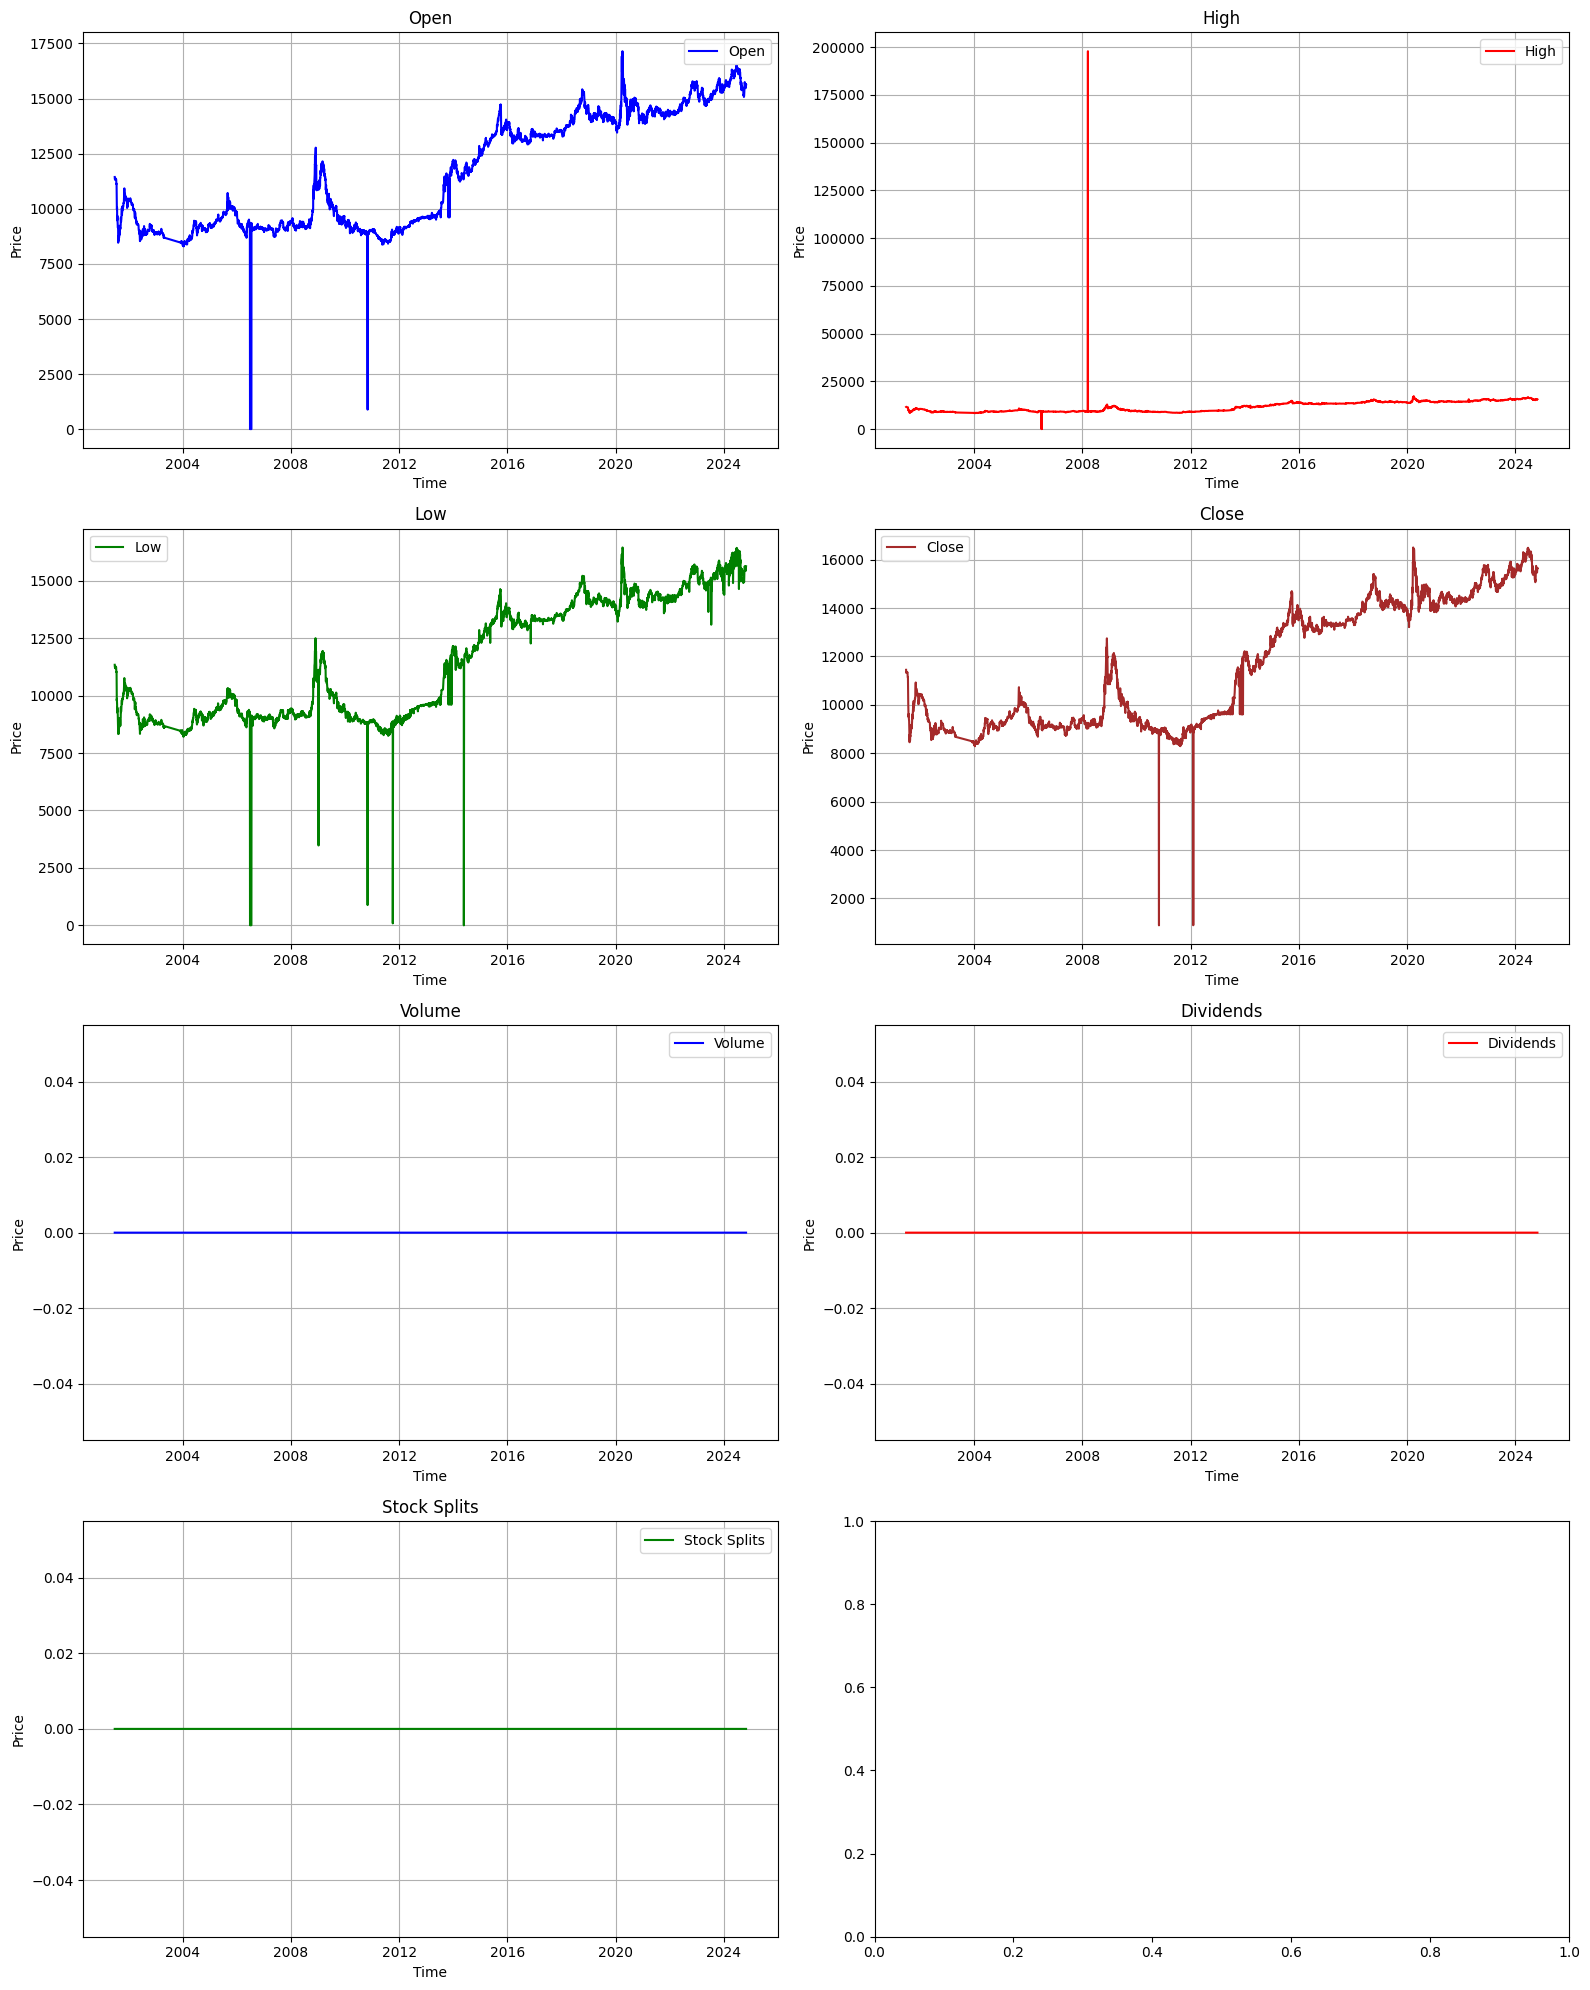

In [9]:
plot_series(idrx_history, columns=idrx_history.columns)

## Looking for 2002-2024 dataset range

In [10]:
idrx_2002_2024 = idrx_history.loc['2002-01-01':'2024-01-01']
idrx_2002_2024

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0


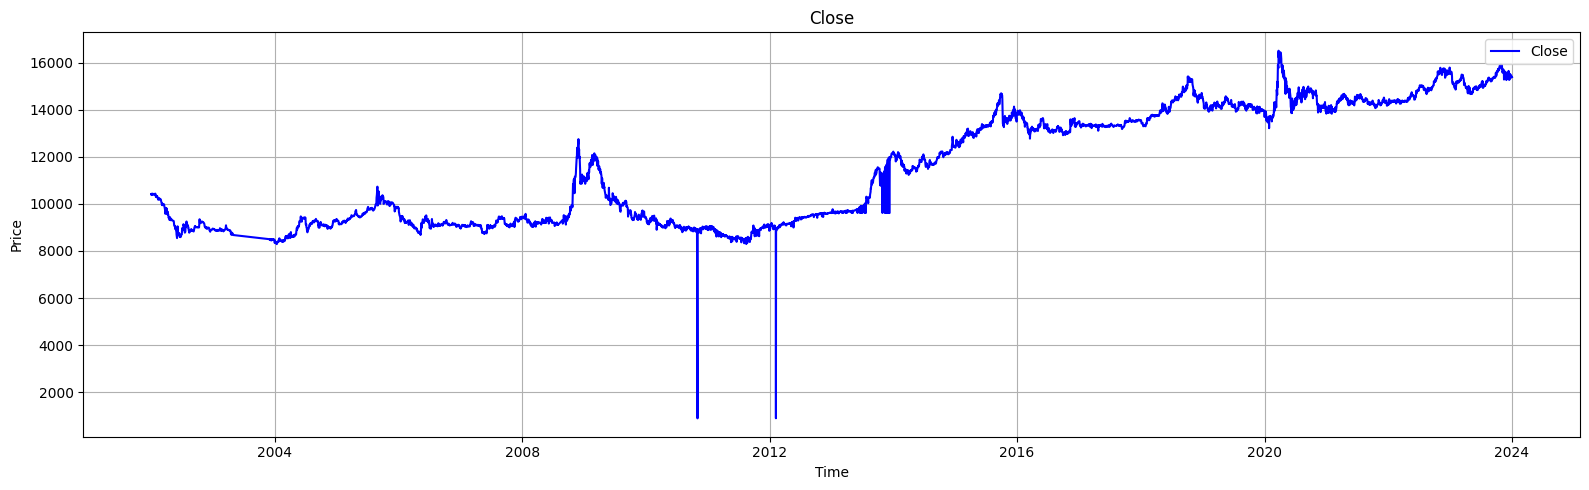

In [11]:
plot_series(idrx_2002_2024, columns=['Close'])

## Save loaded dataset to csv file

In [12]:
# save csv file
def save_csv(df, dir, download=False):
  '''
    All downloaded file will stored in download directory
  '''
  os.makedirs('download', exist_ok=True)
  print(f'Success make dir download')
  save_path = os.path.join('download', dir)
  df.to_csv(save_path)
  print(f'Success save {save_path} to /download{save_path}')

  if download:
    files.download(save_path)

# # Uncomment code below for downloading the file
# save_path = "usd_idr_historical_data_20y.csv"
# # set download to False if you just want to save csv
# save_csv(idrx_history, save_path, download=False)

## Load Dataset

In [13]:
idrx_df = idrx_2002_2024
idrx_df.sort_values(by='Date', ascending=True, inplace=True)

<ipython-input-13-9a7140c1a677>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idrx_df.sort_values(by='Date', ascending=True, inplace=True)


In [14]:
idrx_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0


In [15]:
idrx_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5542 entries, 2002-01-02 00:00:00+00:00 to 2024-01-01 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5542 non-null   float64
 1   High          5542 non-null   float64
 2   Low           5542 non-null   float64
 3   Close         5542 non-null   float64
 4   Volume        5542 non-null   int64  
 5   Dividends     5542 non-null   float64
 6   Stock Splits  5542 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 346.4 KB


In [16]:
for col in idrx_df.columns:
  print(f'{col}: {idrx_df[col].nunique()}')

Open: 4393
High: 4409
Low: 4177
Close: 4355
Volume: 1
Dividends: 1
Stock Splits: 1


`Volume`, `Dividends`, `Stock Splits` does not give much information, so we'll drop it

In [17]:
idrx_df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
idrx_df

<ipython-input-17-50d57ddecc62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idrx_df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)


,Open,High,Low,Close
Date,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000
...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000


Much better! :)

Now we'll look into the moving data point in each columns

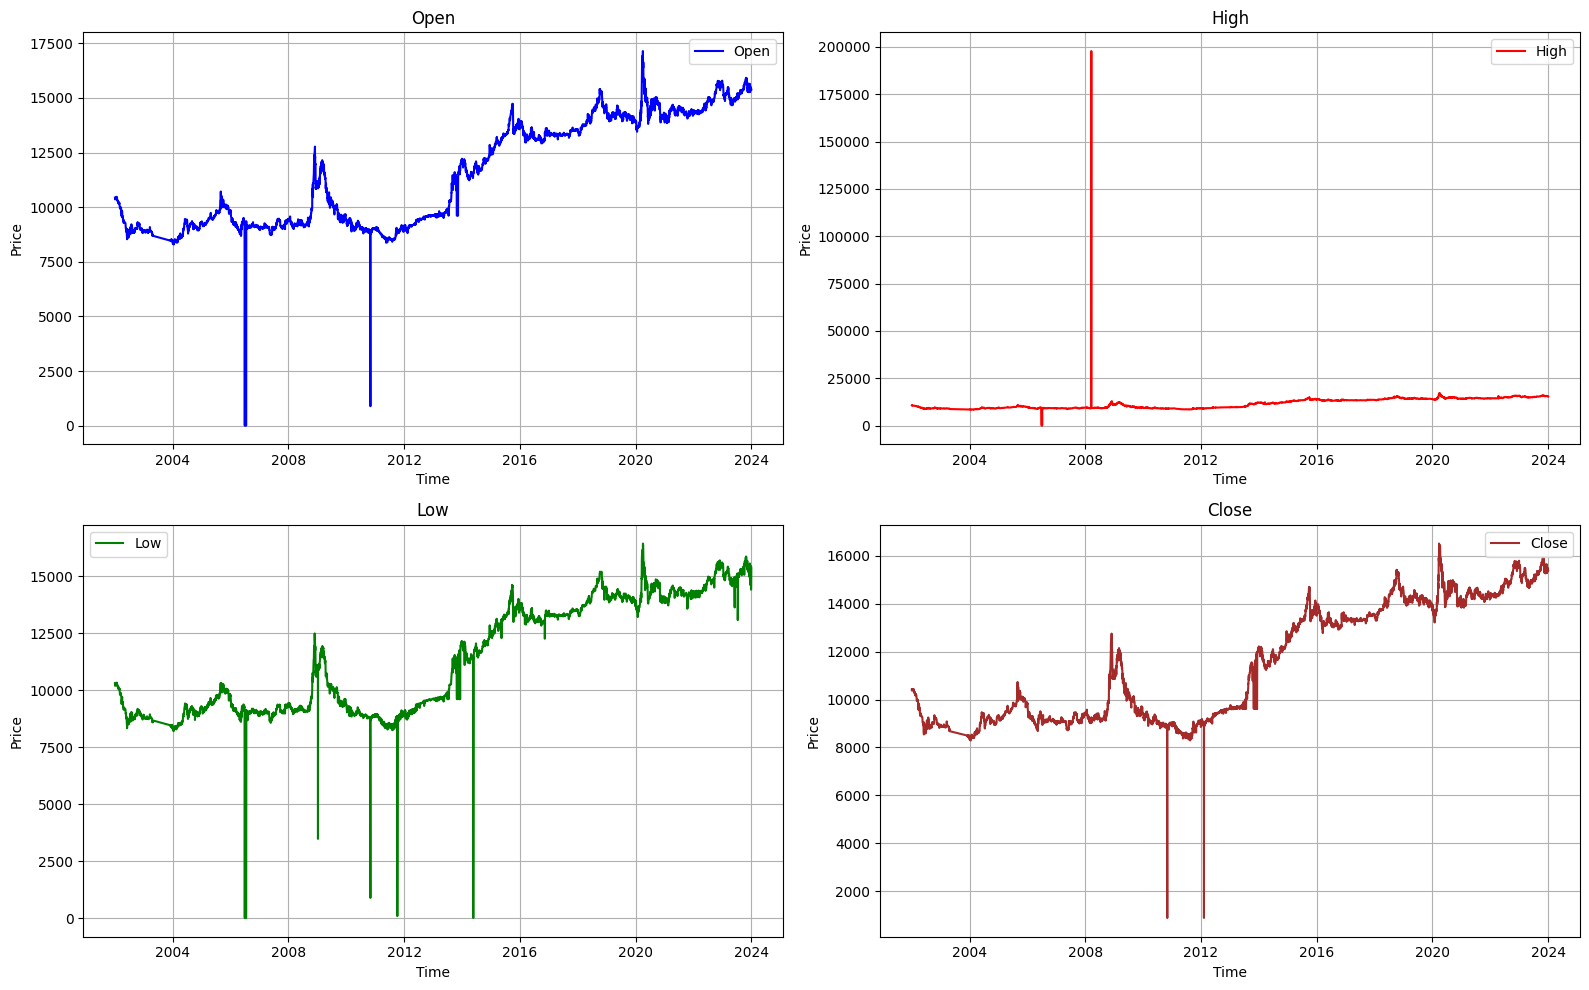

In [18]:
plot_series(idrx_df, columns=idrx_df.columns)

Looks there is outlier in value, and we should handle it later

# Preprocessing

## Check for missing value

In [19]:
idrx_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0


## Looking up the outlier

As seen above, we found the outlier of the dataset, it'll make trained model not performing well. Now we'll look up the case. <br>
The oulier seems happened between 2010 and 2013. But there is different outlier in each columns. Instead, we're going to set the upper and lower bound, which will return value between 5000 and 30000

In [20]:
idrx_df = idrx_df[
    (idrx_df['Close'] > 5000) & (idrx_df['Close'] < 30000) &
     (idrx_df['Open'] > 5000) & (idrx_df['Open'] < 30000) &
      (idrx_df['High'] > 5000) & (idrx_df['High'] < 30000) &
       (idrx_df['Low'] > 5000) &(idrx_df['High'] < 30000)
       ]
idrx_df

,Open,High,Low,Close
Date,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000
...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000


DONE! <br>
Now if we plot the chart again.

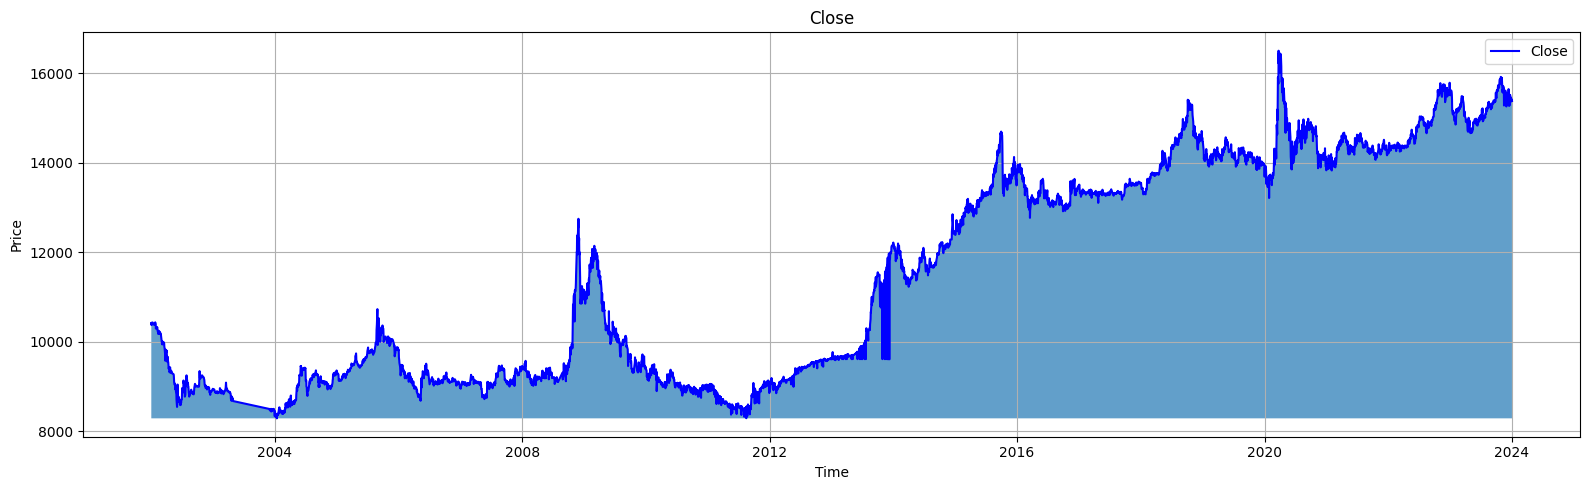

In [21]:
plot_series(idrx_df, columns=['Close'], fillbar=True)

Looks better! And now can we see the significant change of price rate from 2002 to 2024


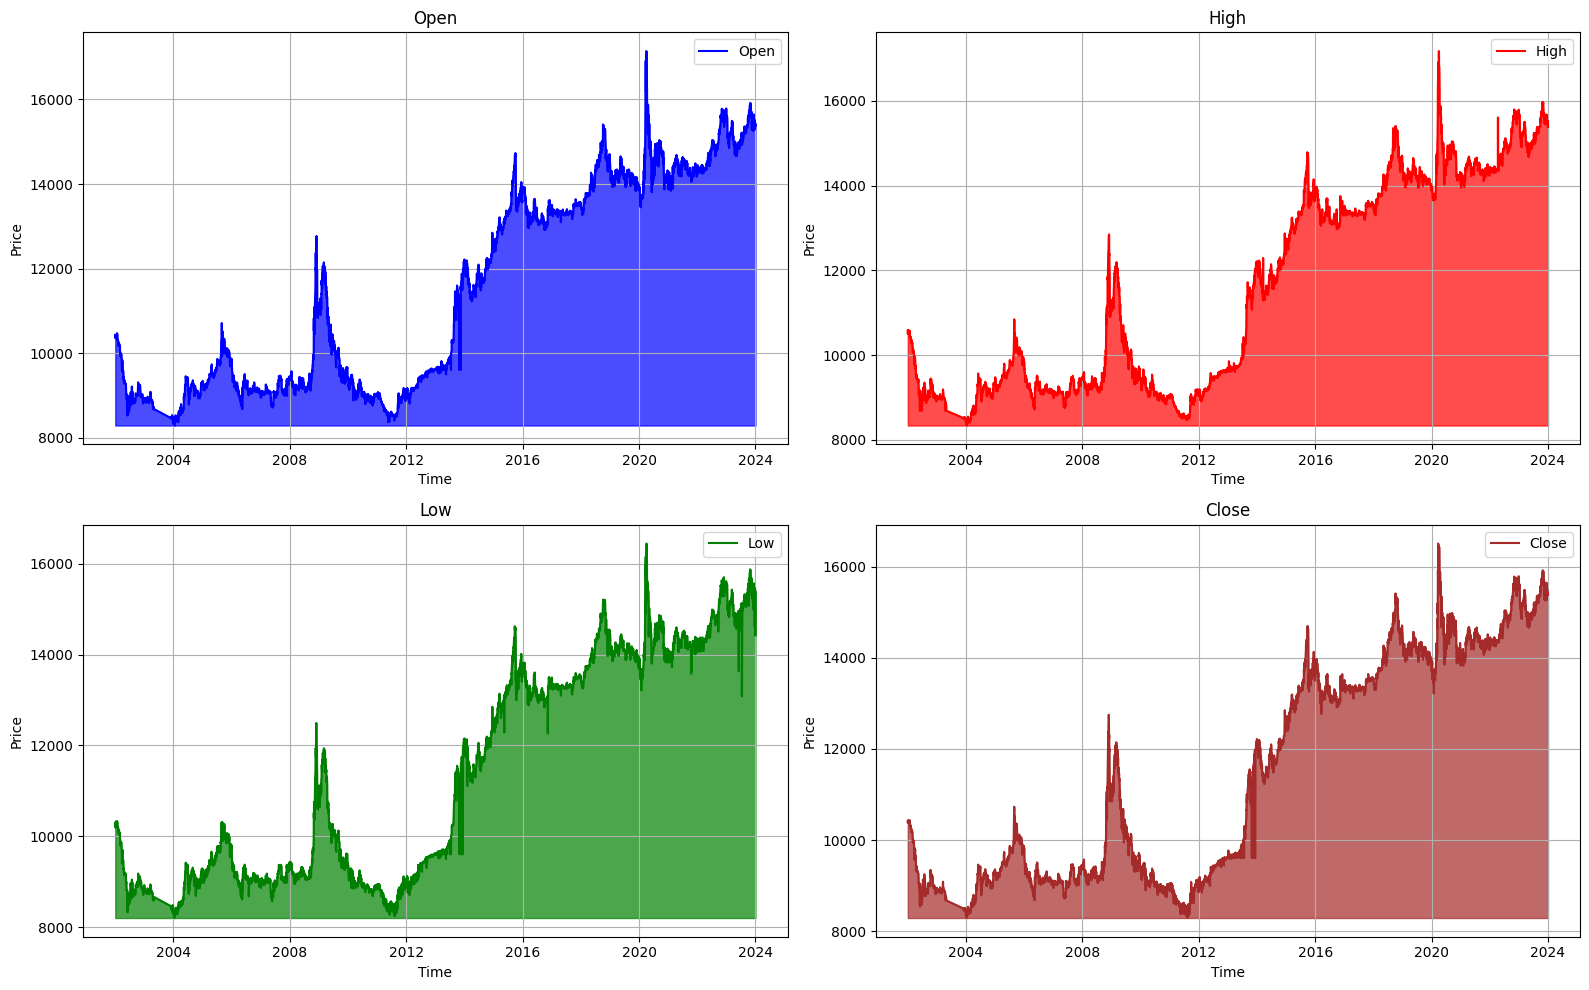

In [22]:
plot_series(idrx_df, columns=idrx_df.columns, fillbar=True)

Now they're looks cleaner

## Check stationary (unit root test)
To determine whether a time series has a unit root (and is thus non-stationary), we typically use tests like the Augmented Dickey-Fuller (ADF) test

In [23]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

def check_stationary(df, columns):

  for num, column in enumerate(columns):

    # Just print the line if checking more than one columns
    if len(columns) > 1 & num > 0:
      print('\n'.ljust(50, '-'))

    # Title for columns that checked
    print(f'{num+1}). ADF For column {column}:')

    # results that contained from adfuller
    results = adfuller(df[column])

    print(f'ADF_statistic: {results[0]}')
    print(f'p-value: {results[1]}')
    print(f'Number of lags used: {results[2]}')

    print(f'Critical Values:')
    for key, value in results[4].items():
      print(f'{key}: {value}')

    if results[1] <= 0.05: # p-value <= 0.05
      print(f"\n\033[32mThe series is stationary!\033[0m")
    else:
      print(f'\n\033[31mThe series is not stationary!\033[0m')



In [24]:
check_stationary(df=idrx_df, columns=idrx_df.columns)

1). ADF For column Open:
ADF_statistic: -0.47808669362452927
p-value: 0.896222259943456
Number of lags used: 32
Critical Values:
1%: -3.4315419039447352
5%: -2.862066702985945
10%: -2.5670503628622288

The series is not stationary!

-------------------------------------------------
2). ADF For column High:
ADF_statistic: -0.5505234086646946
p-value: 0.8817744743967174
Number of lags used: 5
Critical Values:
1%: -3.4315360670336985
5%: -2.8620641241662756
10%: -2.567048990073573

The series is not stationary!
3). ADF For column Low:
ADF_statistic: -0.5322847102209528
p-value: 0.8855608970178754
Number of lags used: 32
Critical Values:
1%: -3.4315419039447352
5%: -2.862066702985945
10%: -2.5670503628622288

The series is not stationary!

-------------------------------------------------
4). ADF For column Close:
ADF_statistic: -0.5759262680737514
p-value: 0.8763294500479335
Number of lags used: 29
Critical Values:
1%: -3.4315412525635978
5%: -2.8620664151979325
10%: -2.5670502096633707



Looks that the series has a unit root (non-stationary), here's now we need to difference the time series

In [25]:
idrx_diff = idrx_df.diff(periods=1)
idrx_diff.dropna(inplace=True)
idrx_diff = pd.DataFrame(idrx_diff)
idrx_diff

,Open,High,Low,Close
Date,,,,
2002-01-03 00:00:00+00:00,-77.000000,-75.0,-37.000000,-40.000000
2002-01-04 00:00:00+00:00,70.000000,100.0,-63.000000,53.000000
2002-01-07 00:00:00+00:00,-38.000000,-72.0,95.000000,-38.000000
2002-01-08 00:00:00+00:00,33.000000,-5.0,33.000000,33.000000
2002-01-09 00:00:00+00:00,10.000000,15.0,-3.000000,-3.000000
...,...,...,...,...
2023-12-26 00:00:00+00:00,50.799805,0.0,-61.500000,50.799805
2023-12-27 00:00:00+00:00,-60.000000,-26.0,-51.099609,-60.000000
2023-12-28 00:00:00+00:00,-27.000000,9.0,21.799805,-27.000000


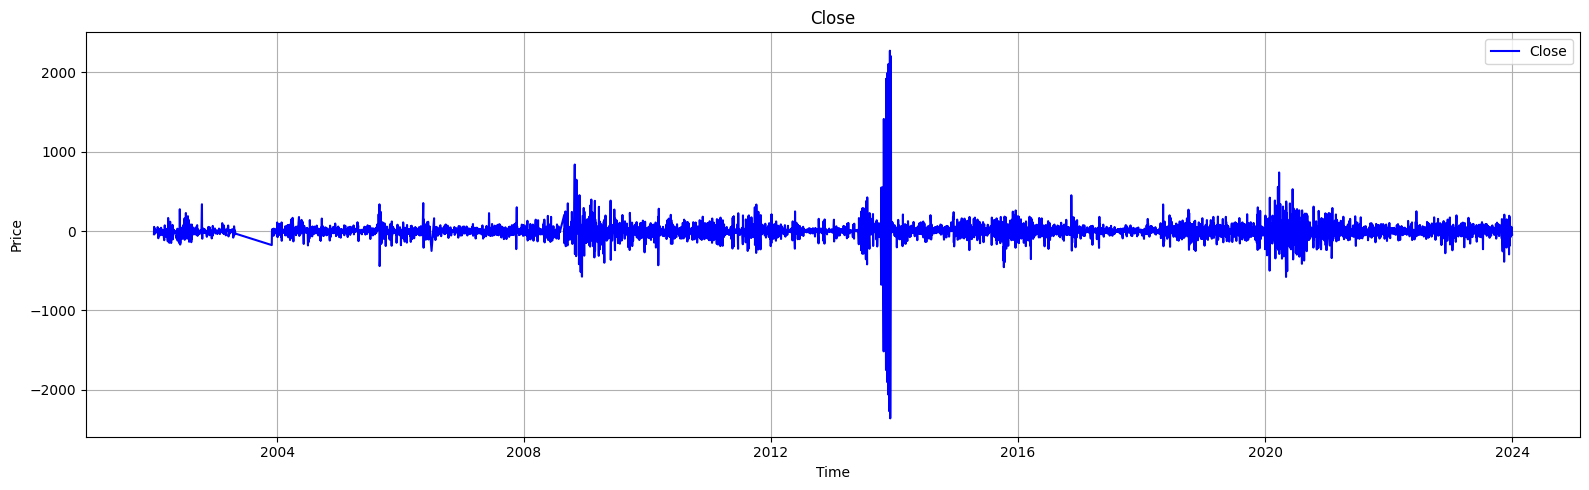

In [26]:
plot_series(idrx_diff, ['Close'])

Looks the data has removed the unit root, now we'll check the stationary using ADF again

In [27]:
check_stationary(idrx_diff, columns=idrx_diff.columns)

1). ADF For column Open:
ADF_statistic: -14.280796405493849
p-value: 1.3250592720372643e-26
Number of lags used: 31
Critical Values:
1%: -3.4315419039447352
5%: -2.862066702985945
10%: -2.5670503628622288

The series is stationary!

-------------------------------------------------
2). ADF For column High:
ADF_statistic: -31.816481096893742
p-value: 0.0
Number of lags used: 4
Critical Values:
1%: -3.4315360670336985
5%: -2.8620641241662756
10%: -2.567048990073573

The series is stationary!
3). ADF For column Low:
ADF_statistic: -13.782419427494329
p-value: 9.243422938165775e-26
Number of lags used: 31
Critical Values:
1%: -3.4315419039447352
5%: -2.862066702985945
10%: -2.5670503628622288

The series is stationary!

-------------------------------------------------
4). ADF For column Close:
ADF_statistic: -14.219393357422224
p-value: 1.6679663394159592e-26
Number of lags used: 28
Critical Values:
1%: -3.4315412525635978
5%: -2.8620664151979325
10%: -2.5670502096633707

The series is st

## Checking ACF and PACF

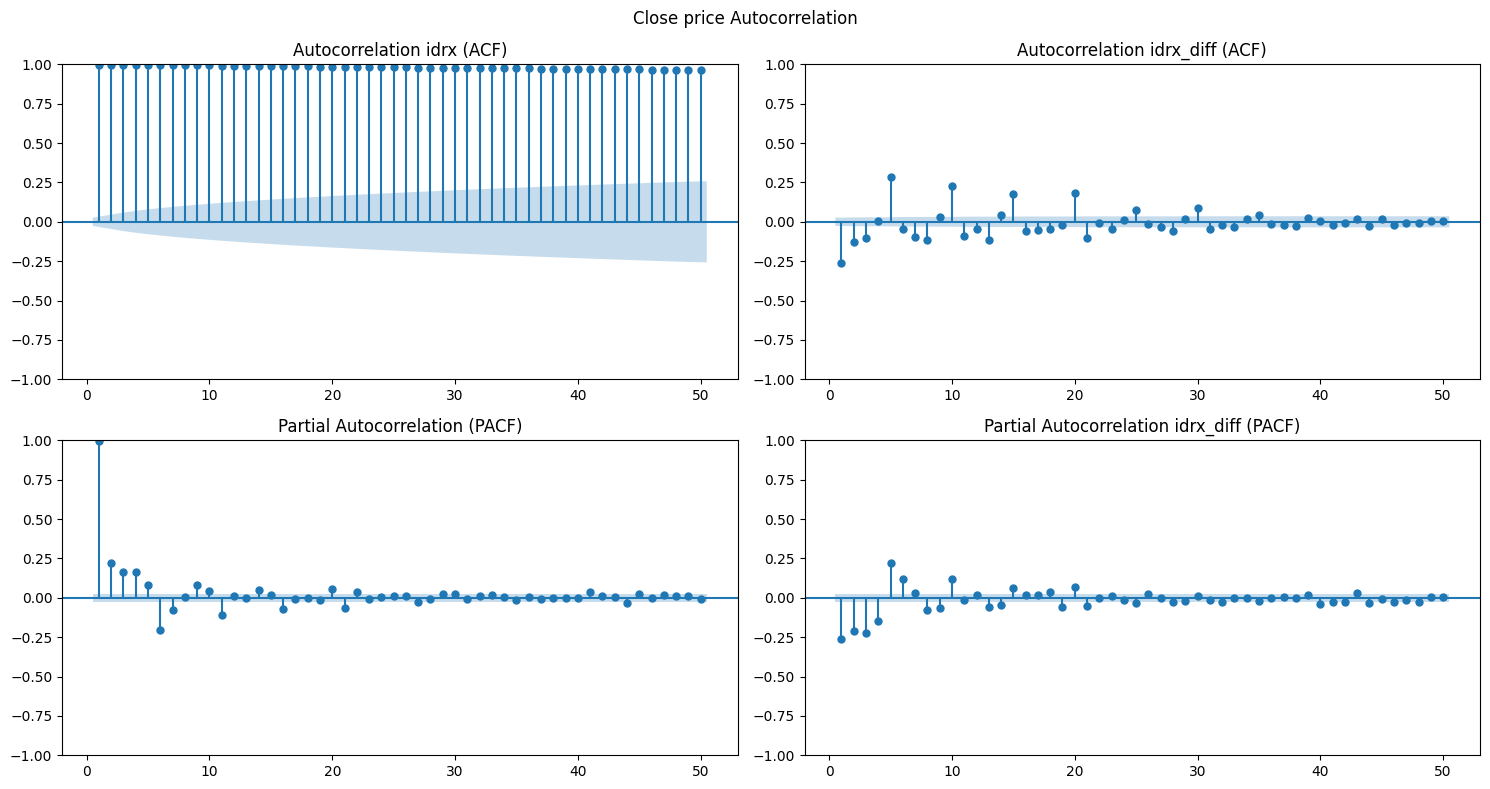

In [28]:
fig, ax = plt.subplots(figsize=(15, 8), ncols=2, nrows=2)
# Plot the ACF
fig.suptitle('Close price Autocorrelation')
plot_acf(idrx_df['Close'], lags=50, title="Autocorrelation idrx (ACF)", zero=False, ax=ax[0][0])
plot_acf(idrx_diff['Close'], lags=50, title="Autocorrelation idrx_diff (ACF)", zero=False, ax=ax[0][1])


# Plot the PACF
plot_pacf(idrx_df['Close'], lags=50, title="Partial Autocorrelation (PACF)", zero=False, ax=ax[1][0])
plot_pacf(idrx_diff['Close'], lags=50, title="Partial Autocorrelation idrx_diff (PACF)", zero=False, ax=ax[1][1])

plt.tight_layout()
plt.show()

**ACF Plot**: If there are significant spikes at certain lags, it indicates that the time series at those lags is correlated with the current values, which may help in deciding the window size. <br>
<br>
**PACF Plot**: Helps determine the number of autoregressive terms. If PACF drops sharply after a few lags, it means that those lags are the most significant for predicting future values.

## Split data

Here we're going to split the dataset into train and valid dataset. Where each will be differenced dataset (stationary) and original dataset (non-stationary), which both would be trained and compared their accuracy to receive a better model

In [29]:
split_time = int(len(idrx_df) * 0.2)
train_series = idrx_df[:-split_time]
valid_series = idrx_df[-split_time:]
train_series_diff = idrx_diff[:-split_time]
valid_series_diff = idrx_diff[-split_time:]

### train test series

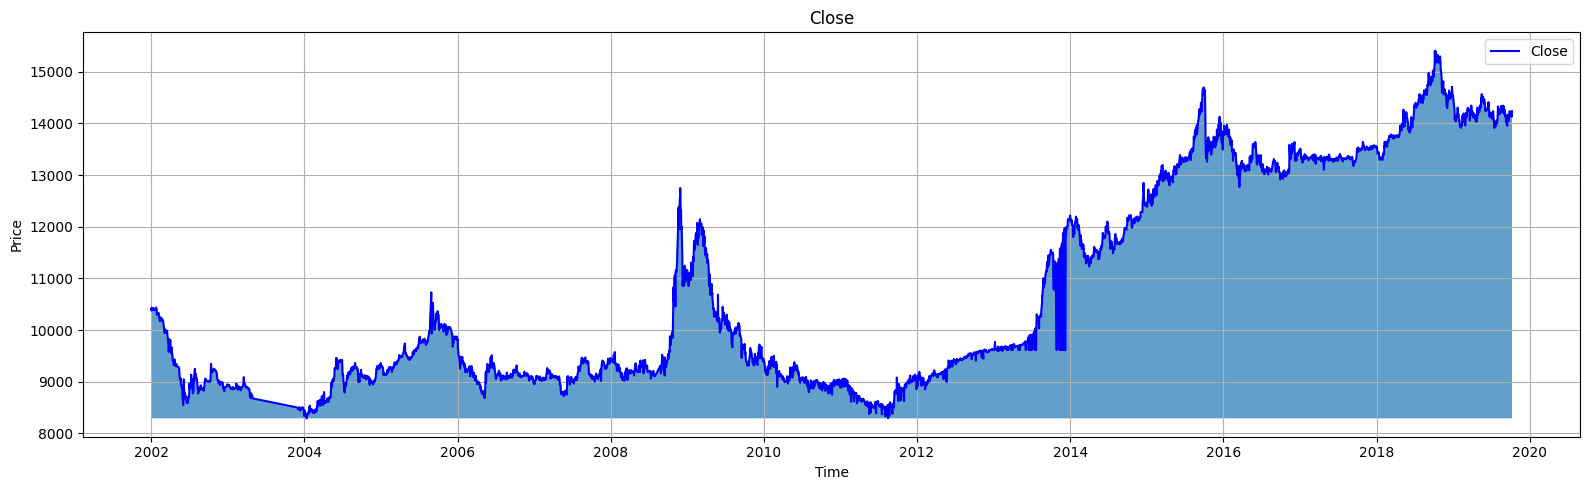

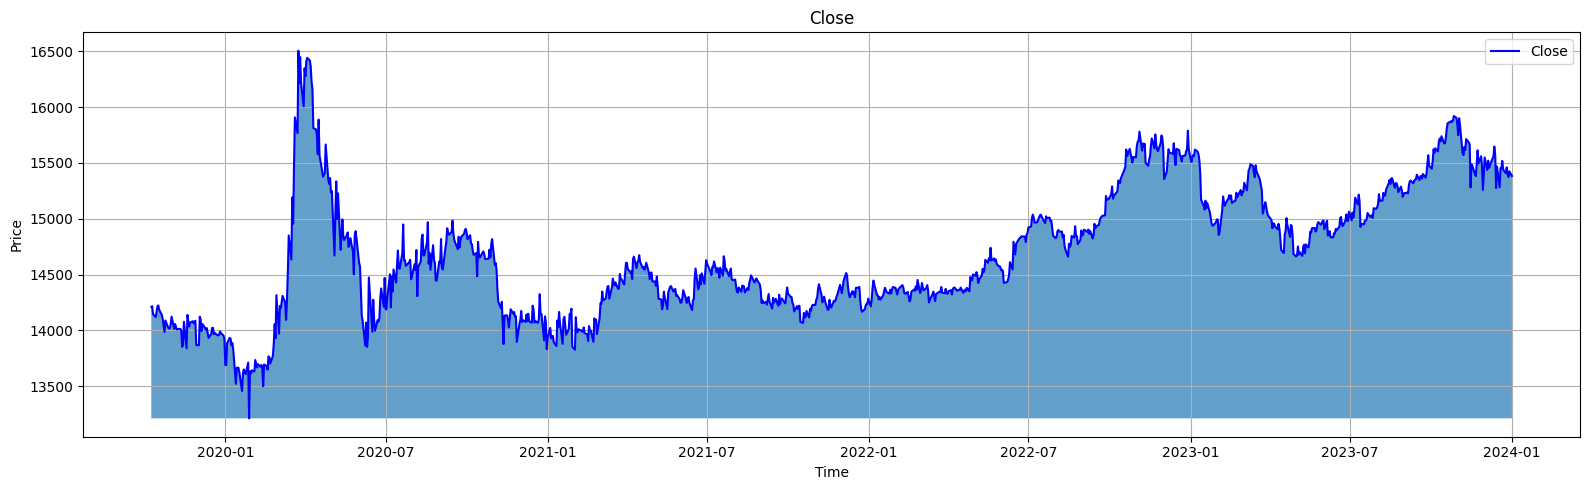

In [30]:
# plot train series
plot_series(train_series, ['Close'], fillbar=True)
# plot validation series
plot_series(valid_series, ['Close'], fillbar=True)

### train test series diff

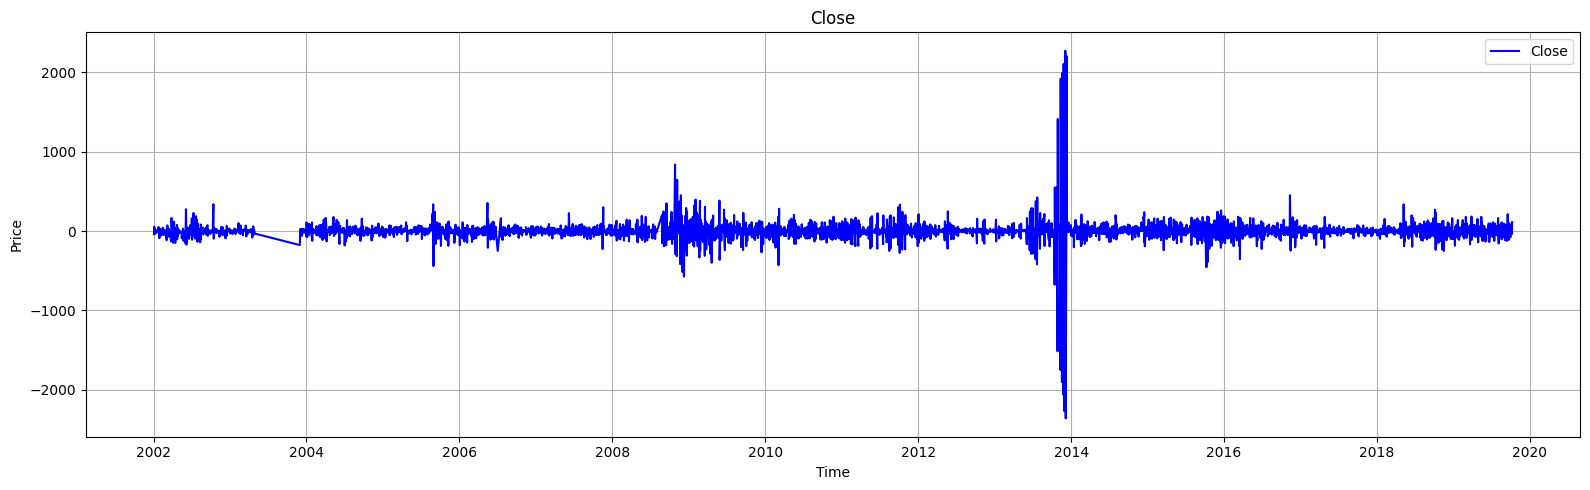

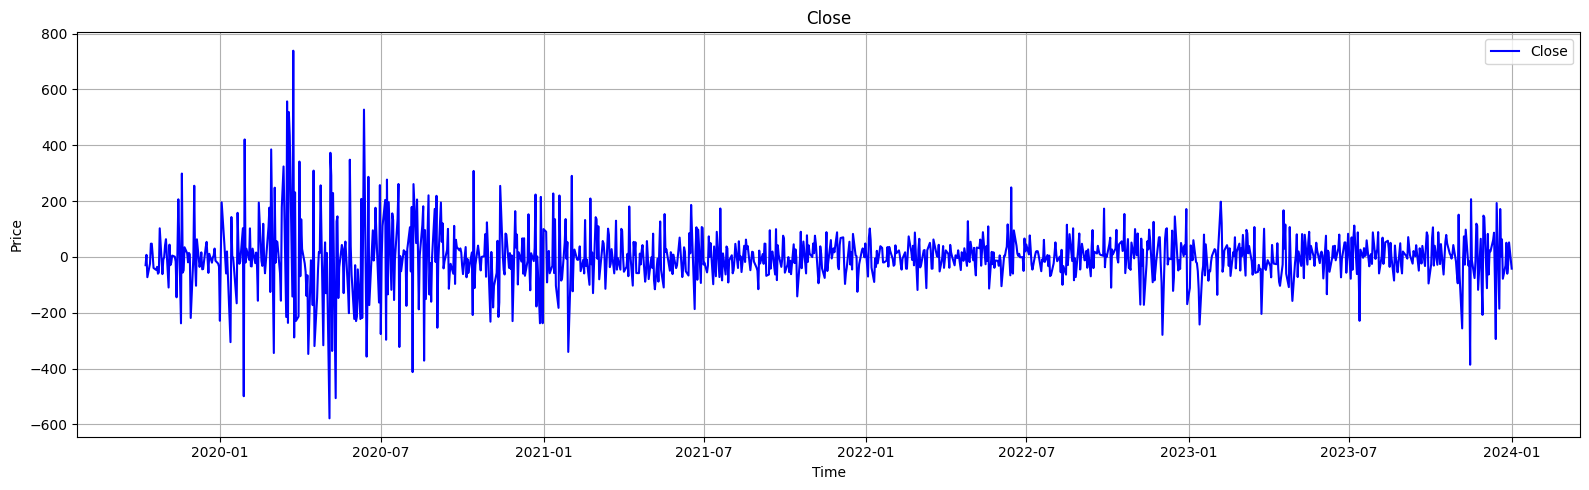

In [31]:
plot_series(train_series_diff, ['Close'])
plot_series(valid_series_diff, ['Close'])

# Windowing Data Series
•	For a Differenced Series (idrx_diff): Start with a window size of 1 or 2, since most of the correlation is explained within those lags.

•	For the Original Series (idrx): If you’re not differencing the series, you might consider a larger window size to account for the strong autocorrelation seen in the ACF (e.g., a window size between 10 to 20).

In [40]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)

  # create tf dataset
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # windowed dataset as window size
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

  # flat the window
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1))

  # map the window to input and target value
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # shuffle the dataset
  dataest = dataset.shuffle(shuffle_buffer)

  # batching the dataset and prefetch 1 data point
  dataset = dataset.batch(batch_size).prefetch(1).repeat(3)
  return dataset

In [41]:
BATCH_SIZE = 32
WINDOW_SIZE = 33 # will be explore more and fine tuned the value
# WINDOW_SIZE_DIFF = 30 # will be explore more and fine tuned the value
SHUFFLE_BUFFER = len(train_series)

train_idrx = windowed_dataset(train_series['Close'], window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)
valid_idrx = windowed_dataset(valid_series['Close'], window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)

In [42]:
for j, data in enumerate(train_idrx.take(2)):
  # Look up the 5 first training datasetes from batch 1 and 2
  print(f'\n\033[1mBATCH: {j}\033[0m '.ljust(50, '-'))
  for i in range(2):
    print(f'\033[32mseries\033[0m: {data[0][i].numpy().shape}\n\033[31mtarget\033[0m: {data[1][i].numpy().shape}')


BATCH: 0 --------------------------------
series: (33, 1)
target: (1,)
series: (33, 1)
target: (1,)

BATCH: 1 --------------------------------
series: (33, 1)
target: (1,)
series: (33, 1)
target: (1,)


# Build the model

In [44]:

def build_model(hp):
  input = Input(shape=(WINDOW_SIZE, 1))
  conv1d = Conv1D(filters=hp.Int('units', min_value=5, max_value=64, step=5),
                  kernel_size=5,
                  activation='relu',
                  strides=1,
                  padding='causal', name='conv1d')(input)

  blstm = Bidirectional(LSTM(
      hp.Int('units', min_value=10, max_value=64, step=5),
      return_sequences=True), name='bidirectional_lstm')(conv1d)

  lstm = LSTM(
      hp.Int('units', min_value=10, max_value=64, step=5),
      return_sequences=True, name='lstm')(blstm)


  # global average pooling
  if hp.Boolean('global_average_pooling1D'):
    flattened = GlobalAveragePooling1D(name='global_average_pooling1D')(lstm)
  else:
    flattened = Flatten(name='flatten')(lstm)


  # start fully connected
  dense = Dense(hp.Int('units', min_value=10, max_value=60, step=3),
                activation='relu', name='dense_1')(flattened)

  # dropout
  if hp.Boolean('dropout'):
    dense = Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1),
                    name='dropout)')(dense)

  dense = Dense(hp.Int('units', min_value=0, max_value=60, step=3),
                activation='relu', name='dense_2')(dense)

  output = Dense(1, name='output')(dense)

  lambda_val = hp.Int('lambda', min_value=100, max_value=10000, step=100)
  lambda_layer = Lambda(lambda x: x * lambda_val, output_shape=(1,), name='lambda_layer')(output)

  model = tf.keras.Model(inputs=input, outputs=lambda_layer)
  model.summary()

  lr = hp.Float('learning_rate', min_value=1e-8, max_value=1e-2, sampling='log')
  momentum = hp.Float('momentum', min_value=0.0, max_value=1.0, step=0.1)

  model.compile(
      loss=tf.keras.losses.Huber(),
      optimizer=tf.keras.optimizers.SGD(
          momentum=momentum,
          learning_rate=lr),
      metrics=[MeanSquaredError()]
  )

  tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True)

  return model

In [45]:
build_model(keras_tuner.HyperParameters())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 33, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 33, 5)               │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm (Bidirectional)   │ (None, 33, 10)              │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 33, 5)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 165)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_layer (Lambda)                │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,656 (6.47 KB)

 Trainable params: 1,656 (6.47 KB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_1, built=True>

## Keras Tuner

In [46]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective('val_mean_squared_error', direction='min'),
    max_trials=3,
    executions_per_trial=2,
    overwrite=False,
    directory="keras_tuner",
    project_name="usdidr=x_prediction",
)

Reloading Tuner from keras_tuner/usdidr=x_prediction/tuner0.json


In [47]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 64, 'step': 3, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
global_average_pooling1D (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
lambda (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 10000, 'step': 100, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 1.0, 'step': 0.1, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [48]:
tuner.search(train_idrx, epochs=50, validation_data=valid_idrx)

Trial 3 Complete [00h 10m 40s]
val_mean_squared_error: 413060.234375

Best val_mean_squared_error So Far: 323440.234375
Total elapsed time: 00h 29m 22s


In [49]:
tuner.results_summary()

Results summary
Results in keras_tuner/usdidr=x_prediction
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 1 summary
Hyperparameters:
units: 17
activation: relu
global_average_pooling1D: True
dropout: False
lambda: 7800
learning_rate: 3.323014111669753e-07
momentum: 0.9
dropout_rate: 0.1
Score: 323440.234375

Trial 2 summary
Hyperparameters:
units: 41
activation: relu
global_average_pooling1D: True
dropout: False
lambda: 3300
learning_rate: 2.3415648285714325e-05
momentum: 0.4
dropout_rate: 0.0
Score: 413060.234375

Trial 0 summary
Hyperparameters:
units: 8
activation: relu
global_average_pooling1D: False
dropout: True
lambda: 8000
learning_rate: 0.000902595306648127
momentum: 0.1
dropout_rate: 0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/pytho

In [50]:
models = tuner.get_best_models(num_models=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 33, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 33, 17)              │             102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm (Bidirectional)   │ (None, 33, 34)              │           4,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 33, 17)              │           3,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1D             │ (None, 17)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 17)                  │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_layer (Lambda)                │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,028 (35.27 KB)

 Trainable params: 9,028 (35.27 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 19 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:

best_model = models[0]

In [52]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 33, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 33, 17)              │             102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm (Bidirectional)   │ (None, 33, 34)              │           4,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 33, 17)              │           3,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1D             │ (None, 17)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 17)                  │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_layer (Lambda)                │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,028 (35.27 KB)

 Trainable params: 9,028 (35.27 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
best_model.save('best_model.keras')

## End of keras tuning (be careful to run the code above)

# Train the model

In [54]:
best_hps = tuner.get_best_hyperparameters(5)
for hp in best_hps:
  print(hp.values)

{'units': 17, 'activation': 'relu', 'global_average_pooling1D': True, 'dropout': False, 'lambda': 7800, 'learning_rate': 3.323014111669753e-07, 'momentum': 0.9, 'dropout_rate': 0.1}
{'units': 41, 'activation': 'relu', 'global_average_pooling1D': True, 'dropout': False, 'lambda': 3300, 'learning_rate': 2.3415648285714325e-05, 'momentum': 0.4, 'dropout_rate': 0.0}
{'units': 8, 'activation': 'relu', 'global_average_pooling1D': False, 'dropout': True, 'lambda': 8000, 'learning_rate': 0.000902595306648127, 'momentum': 0.1, 'dropout_rate': 0.0}


In [55]:
# Build the model with the best hp.
best_model = build_model(best_hps[0])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 33, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 33, 17)              │             102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm (Bidirectional)   │ (None, 33, 34)              │           4,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 33, 17)              │           3,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1D             │ (None, 17)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 17)                  │             306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_layer (Lambda)                │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,028 (35.27 KB)

 Trainable params: 9,028 (35.27 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Fit the model
history = best_model.fit(train_idrx,
                    epochs=50,
                    validation_data=valid_idrx,
                    batch_size=BATCH_SIZE)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 2454.0149 - mean_squared_error: 14509501.0000 - val_loss: 475.5054 - val_mean_squared_error: 322011.1562
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1573.8251 - mean_squared_error: 5075253.5000 - val_loss: 500.5211 - val_mean_squared_error: 436998.5312
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 2047.4221 - mean_squared_error: 7585595.5000 - val_loss: 503.0678 - val_mean_squared_error: 441925.4375
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2160.6436 - mean_squared_error: 8362732.0000 - val_loss: 511.3932 - val_mean_squared_error: 457056.3750
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2096.3496 - mean_squared_error: 7912390.5000 - val_loss: 511.3398 - val_mean_squared_error: 456962.8750
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2096.6379 - mean_squared_error: 7911110.5000 - val_loss: 499.5218 - val_mean_squared_error: 434951.7812
Epoch 7/

In [57]:
def plot_history(history):
  params = [keys for keys in history.history.keys()]
  print(params)
  epochs = range(len(history.history['loss']))

  ncols = 2
  nrows= len(params)//ncols//2
  fig, axs = plt.subplots(figsize=(16, 5*nrows), ncols=ncols, nrows=nrows)
  axs = axs.flatten()

  # Iterate over axses objects in the grid
   # Access and iterate over individual axses in the grid
  for i, param in enumerate(list(params)):
    if 'val' not in param:
      axs[i].set_title(param)
      axs[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
      axs[i].set_title(param)
      axs[i].plot(epochs, history.history[param], label=param)

      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel('Loss')
      axs[i].grid(True)
      axs[i].legend()

  plt.show()

['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']


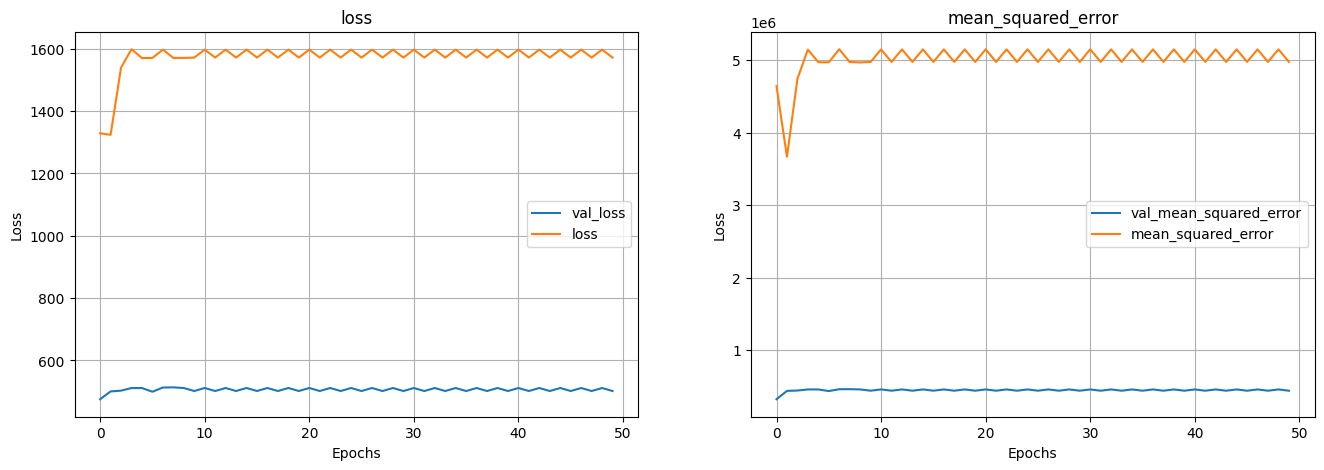

In [58]:
plot_history(history)

In [59]:
history_data = history.history
history_df = pd.DataFrame(history_data, columns=history_data.keys())
history_df['average'] = history_df.mean(axis=1)
history_df.sort_values(by='average', ascending=True).head()

,loss,mean_squared_error,val_loss,val_mean_squared_error,average
1,1323.949829,3669302.25,500.521057,436998.53125,1.027031e+06
0,1328.997314,4644025.00,475.505402,322011.15625,1.241960e+06
2,1539.881226,4744935.50,503.067780,441925.43750,1.297226e+06
5,1570.620850,4973314.50,499.521790,434951.78125,1.352584e+06
11,1571.758301,4978597.00,501.891449,439689.25000,1.355090e+06


## Plot on data

In [60]:
def model_forecast(model, series, window_size, batch_size):
  # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    dataset = dataset.repeat(3)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [61]:
forecast_series = idrx_df['Close'].iloc[WINDOW_SIZE:]
forecast_series = pd.DataFrame(model_forecast(best_model, forecast_series, WINDOW_SIZE, BATCH_SIZE), columns=['forecast'])

513/513 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [62]:
forecast_series

,forecast
0,14360.955078
1,14360.955078
2,14360.955078
3,14360.955078
4,14360.955078
...,...
16366,14360.955078
16367,14360.955078
16368,14360.955078
16369,14360.955078


In [63]:

actual_forecast_df = pd.concat([actual_series, forecast_series], axis=1)
actual_forecast_df

NameError: name 'actual_series' is not defined

In [ ]:
def plot_forecast(y_true, y_pred):
  plt.plot(y_true, label='actual')
  plt.plot(y_pred, label='forecast')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
plot_forecast(actual_forecast_df['Close'], actual_forecast_df['forecast'])